<font size=6>Comparing results across models using data behind DeepSTARR</font>
<br>
<font size=4>This notebook follows the process behind training multiple models to predict Dev enhancer activity from DNA sequence. This notebook was completed by following the notebook:https://github.com/ML4GLand/tutorials/blob/main/eugene/train/pytorch_lightning/multitask_regression.ipynb</font>
<br>
<font size=4>Link to original DeepSTARR article:https://www.nature.com/articles/s41588-022-01048-5</font>

In [50]:
!pip install 'eugene-tools'

In [51]:
# Imports
import os
import torch
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seqdatasets
import seqdata as sd
import xarray as xr
from eugene import preprocess as pp
from eugene.models.zoo import DeepBind, DeepSTARR
from eugene.models import SequenceModule
from eugene.models.base._metrics import calculate_metric
from eugene import plot as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger

cwd = os.getcwd()
print(cwd)

/content/drive/MyDrive/Colab Notebooks/MP1


In [52]:
# Access GPU
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Fall back to CPU
    print("GPU is not available. Using CPU.")

GPU is available. Using: Tesla T4


In [53]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/MP1')
cwd = os.getcwd()

Mounted at /content/drive


In [54]:
from eugene import settings
settings.config_dir = "./configs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "./dataset" # Directory where EUGENe will download datasets to
settings.logging_dir = "./logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./output" # Directory where EUGENe will save output files to
settings.figure_dir = "./figures" # Directory to specify to EUGENe to save figures to

In [55]:
import seqdatasets

# Load in different deAlmeida22 dataset parts
sdata = seqdatasets.deAlmeida22()
# sdata_val = seqdatasets.deAlmeida22(dataset='val')
# sdata_test = seqdatasets.deAlmeida22(dataset='test')

Dataset deAlmeida22 Sequences_Train.fa has already been downloaded.
Dataset deAlmeida22 Sequences_activity_Train.txt has already been downloaded.
Zarr file found. Opening existing zarr file.


In [56]:
from eugene import preprocess as pp
# One hot encode all the sequences in the sdata using the wrapper function
pp.ohe_seqs_sdata(sdata, alphabet="DNA")
# pp.ohe_seqs_sdata(sdata_val, alphabet="DNA")
# pp.ohe_seqs_sdata(sdata_test, alphabet="DNA")

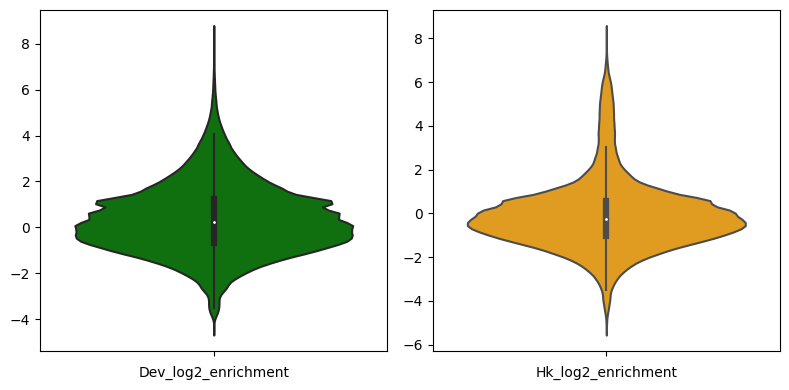

In [57]:
from eugene import plot as pl

# Plot the distribution of targets across the different species the promoters were derived from
# Create a figure with 1 row and 2 columns for subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # figsize can be adjusted for plot size

# First violin plot
ax1 = pl.violinplot(sdata, vars=["Dev_log2_enrichment"], return_axes=True, ax=axes[0], color='green')

# Second violin plot
ax1 = pl.violinplot(sdata, vars=["Hk_log2_enrichment"], return_axes=True, ax=axes[1], color='orange')

plt.tight_layout()
plt.show()

In [60]:
# Split data
pp.ohe_seqs_sdata(sdata)
pp.make_unique_ids_sdata(sdata)
pp.train_test_random_split(sdata, dim="_sequence", test_size=0.2)
sdata["ohe_seq"] = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length")
sdata

<xarray.Dataset>
Dimensions:                                  (_sequence: 402296, _length: 249,
                                              _ohe: 4, length: 249)
Coordinates:
  * _sequence                                (_sequence) object 'chr2L_5587_5...
Dimensions without coordinates: _length, _ohe, length
Data variables:
    Dev_log2_enrichment                      (_sequence) float64 dask.array<chunksize=(402296,), meta=np.ndarray>
    Dev_log2_enrichment_quantile_normalized  (_sequence) float64 dask.array<chunksize=(402296,), meta=np.ndarray>
    Dev_log2_enrichment_scaled               (_sequence) float64 dask.array<chunksize=(402296,), meta=np.ndarray>
    Hk_log2_enrichment                       (_sequence) float64 dask.array<chunksize=(402296,), meta=np.ndarray>
    Hk_log2_enrichment_quantile_normalized   (_sequence) float64 dask.array<chunksize=(402296,), meta=np.ndarray>
    Hk_log2_enrichment_scaled                (_sequence) float64 dask.array<chunksize=(402296,), meta=np.ndarray>
    seq                                      (_sequence, _length) |S1 dask.array<chunksize=(1000, 249), meta=np.ndarray>
    ohe_seq                                  (_sequence, _ohe, length) uint8 ...
    id                                       (_sequence) <U9 'seq000000' ... ...
    train_val                                (_sequence) bool True ... True

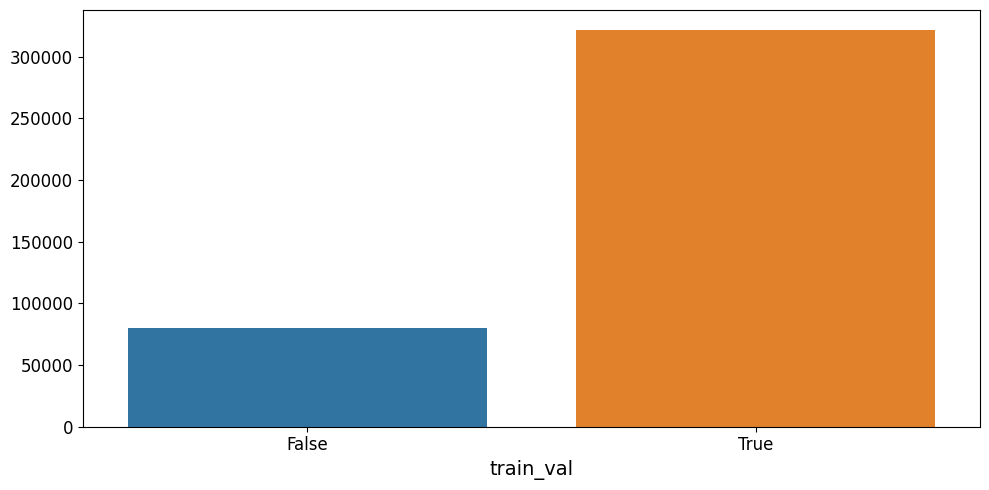

In [61]:
# Check the split with a count plot
pl.countplot(sdata, vars="train_val", orient="h")

In [62]:
# Set-up target
sdata["target"] = sdata["Dev_log2_enrichment"].load()  # single task regression

In [63]:
# Split into train and val
train_mask = np.where(sdata["train_val"])[0]
train_sdata = sdata.isel(_sequence=train_mask)
train_dataloader = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=True,
    drop_last=True,
    batch_size=128,
    num_workers=2
)
val_sdata = sdata.isel(_sequence=~train_mask)
val_dataloader = sd.get_torch_dataloader(
    val_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    prefetch_factor=None,
    shuffle=False,
    drop_last=True,
    batch_size=128,
    num_workers=2
)

In [64]:
os.listdir("./configs")

['CNN.yaml', 'Hybrid.yaml']

### First Model:
The first model tested was a simple CNN designed to be a scaled down version. The model includes three one-dimensional (1D) convolutional layers, each with 256 filters of size 13. Each of these convolutional layers is followed by a nonlinear ReLU activation, max pooling (size=2), dropout (0.3), and batch normalization, respectively.

In [65]:
from eugene import models

# Import 1st model
CNN = models.load_config("CNN.yaml")
# CNN # uncomment if you would like to see model details

### Second Model:
The second model tested is EUGENe's HybridalaJores21, again, adjusted to match the dataset's dimensions. This model also includes three 1D convolutional layers, each with 256 filters of size 13. However, each of these convolutional layers is followed by, in order, dropout (0.3), batch normalization, and non-linear ReLU activations. These convolutional layers are followed by a recurrent layer of size 128, and finally a dense layer that includes a hidden layer with 64 neurons, dropout (0.2), and batch normalization.

In [92]:
# Import 2nd model
Hybrid = models.load_config("Hybrid.yaml")
# Hybrid # uncomment if you would like to see model details

### Third Model:
The third model is a recreation of the DeepSTARR model from EUGENe's model zoo. The model features four 1D convolutional layers (filters = 246, 60, 60, 120; size = 7, 3, 5, 3), each followed by batch normalization, a ReLU nonlinearity, and max-pooling (size = 2). After the convolutional layers, there are two fully connected layers, each with 256 neurons and followed by batch normalization, a ReLU nonlinearity, and dropout where the fraction is 0.4.

In [67]:
from eugene.models.zoo._cre_activity_predictors import DeepSTARR

# Initialize DeepSTARR model
DeepSTARR = DeepSTARR(input_len=249, output_dim=1)
# DeepSTARR # uncomment if you would like to see model details

In [68]:
# Initialize model weights
models.init_weights(CNN)
models.init_weights(Hybrid)
models.init_weights(DeepSTARR)

In [69]:
from eugene import train
from eugene.train import _fit


# Training CNN Architecture

In [70]:
# Test out a batch to make sure the architecture works
batch = next(iter(train_dataloader))
seq = batch["ohe_seq"]
target = batch["target"]
outs = CNN(seq)
seq.shape, target.shape, outs.shape

(torch.Size([128, 4, 249]), torch.Size([128]), torch.Size([128, 1]))

In [80]:
from eugene.models import SequenceModule

# Wrap the architecture in a SequenceModule to allow for easy training
model = SequenceModule(
    arch=CNN,
    task="regression",
    arch_name="DeepSTARR",
    model_name="CNN_regression",
    scheduler="reduce_lr_on_plateau",
    metric="r2score",
)
model.summary()

Model: SequenceModule
Sequence length: 249
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | arch         | SequenceModule | 2.0 M  | train
1 | train_metric | R2Score        | 0      | train
2 | val_metric   | R2Score        | 0      | train
3 | test_metric  | R2Score        | 0      | train
--------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.190     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode

In [72]:
from eugene.models.base._metrics import calculate_metric

# Make sure the models metrics are working properly
calculate_metric(
    metric=model.train_metric,
    metric_name=model.metric_name,
    metric_kwargs=None,
    outs=model(seq),
    y=target
)
model.train_metric.compute()

tensor(-0.8318)

In [73]:
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger

# Set-up a logger so we can track training progress
logger = TensorBoardLogger(
    save_dir=cwd,
    name="CNN_regression",
    version="0.0.1"
)

In [76]:
# Set-up a trainer
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"),
    save_top_k=3,
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())
trainer = Trainer(
    max_epochs=3,
    logger=logger,
    devices=1,
    accelerator="auto",
    callbacks=callbacks,
    fast_dev_run=False,
    num_sanity_val_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [77]:
# Re-initialize weights before training
models.init_weights(CNN)

In [78]:
# Fit the model to the data
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | arch         | SequenceModule | 2.0 M  | train
1 | train_metric | R2Score        | 0      | train
2 | val_metric   | R2Score        | 0      | train
3 | test_metric  | R2Score        | 0      | train
--------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.190     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


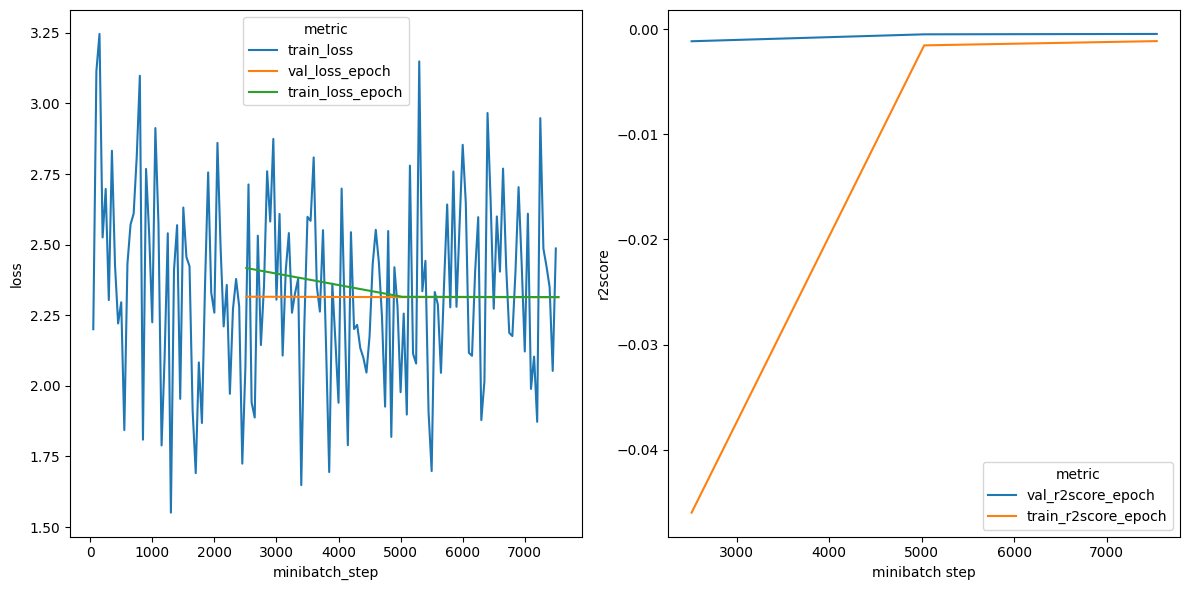

In [79]:
# Visualize the training progress
pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="r2score")

# Training Hybrid Architecture

In [93]:
batch = next(iter(train_dataloader))
seq = batch["ohe_seq"]
target = batch["target"]
outs = Hybrid(seq)
seq.shape, target.shape, outs.shape

(torch.Size([128, 4, 249]), torch.Size([128]), torch.Size([128, 1]))

In [94]:
# Wrap the architecture in a SequenceModule to allow for easy training
model = SequenceModule(
    arch=Hybrid,
    task="regression",
    arch_name="Hybrid",
    model_name="Hybrid_regression",
    scheduler="reduce_lr_on_plateau",
    metric="r2score",
)

In [95]:
# Set-up a logger so we can track training progress
logger = TensorBoardLogger(
    save_dir=cwd,
    name="Hybrid_regression",
    version="0.0.1"
)

In [96]:
# Set-up a trainer
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"),
    save_top_k=3,
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())
trainer = Trainer(
    max_epochs=3,
    logger=logger,
    devices=1,
    accelerator="auto",
    callbacks=callbacks,
    fast_dev_run=False,
    num_sanity_val_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [97]:
# Re-initialize weights before training
models.init_weights(Hybrid)

# Fit the model to the data
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | arch         | SequenceModule | 1.9 M  | train
1 | train_metric | R2Score        | 0      | train
2 | val_metric   | R2Score        | 0      | train
3 | test_metric  | R2Score        | 0      | train
--------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


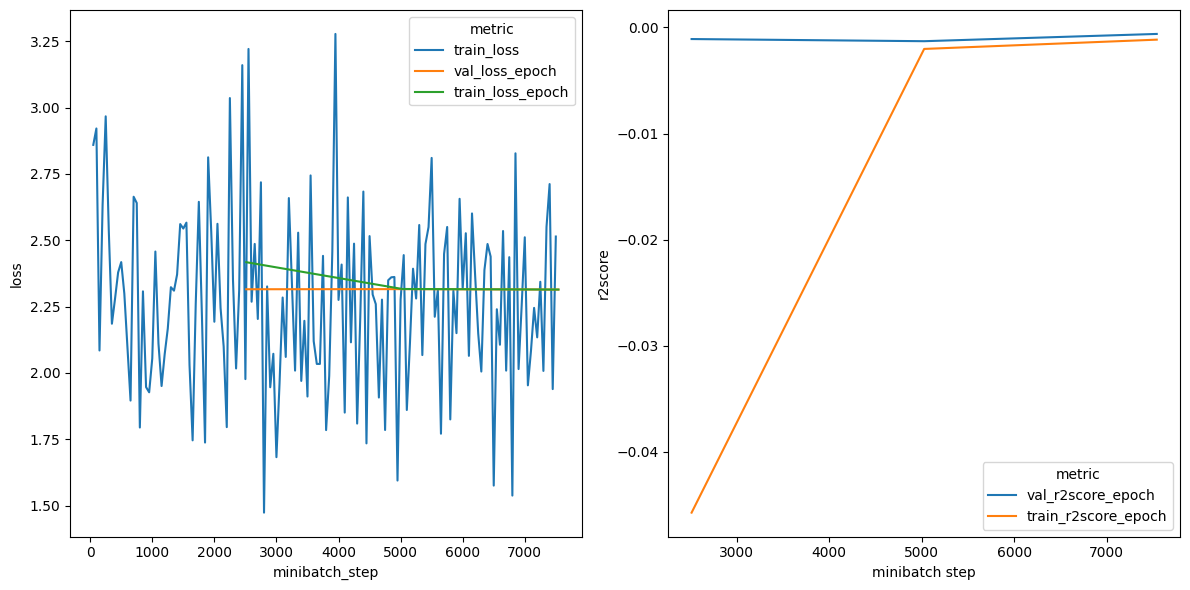

In [98]:
# Visualize the training progress
pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="r2score")

# Training DeepSTARR Architecture


In [99]:
batch = next(iter(train_dataloader))
seq = batch["ohe_seq"]
target = batch["target"]
outs = DeepSTARR(seq)
seq.shape, target.shape, outs.shape

(torch.Size([128, 4, 249]), torch.Size([128]), torch.Size([128, 1]))

In [100]:
# Wrap the architecture in a SequenceModule to allow for easy training
model = SequenceModule(
    arch=DeepSTARR,
    task="regression",
    arch_name="DeepSTARR",
    model_name="DeepSTARR_regression",
    scheduler="reduce_lr_on_plateau",
    metric="r2score",
)

In [101]:
# Set-up a logger so we can track training progress
logger = TensorBoardLogger(
    save_dir=cwd,
    name="DeepSTARR_regression",
    version="0.0.1"
)

In [102]:
# Set-up a trainer
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(logger.save_dir, logger.name, logger.version, "checkpoints"),
    save_top_k=3,
    monitor="val_loss_epoch"
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=3,
    mode="min",
    verbose=False,
)
callbacks.append(early_stopping_callback)
if model.scheduler is not None:
    callbacks.append(LearningRateMonitor())
trainer = Trainer(
    max_epochs=3,
    logger=logger,
    devices=1,
    accelerator="auto",
    callbacks=callbacks,
    fast_dev_run=False,
    num_sanity_val_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [103]:
# Re-initialize weights before training
models.init_weights(DeepSTARR)

# Fit the model to the data
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type      | Params | Mode 
---------------------------------------------------
0 | arch         | DeepSTARR | 7.7 M  | train
1 | train_metric | R2Score   | 0      | train
2 | val_metric   | R2Score   | 0      | train
3 | test_metric  | R2Score   | 0      | train
---------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.744    Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


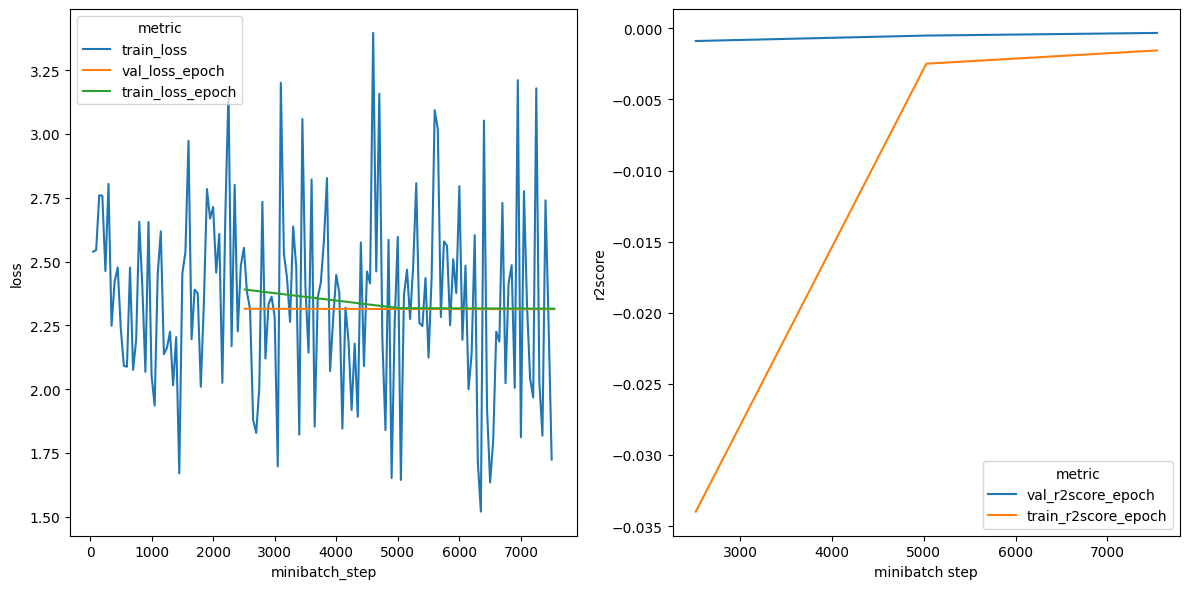

In [104]:
# Visualize the training progress
pl.training_summary(os.path.join(logger.save_dir, logger.name, logger.version), metric="r2score")

# Analysis of Model Performances
As we can see, all three models converge quite quickly, which I'm guessing is due to our large dataset. All three models effectively reach convergence after the second epoch. From the eye test it appears as if the two EUGENe derived models perform better based on r2 score, however this would require further analysis as all three models perform exceptionally well.